Notebook utilizzato per la selezione dei parametri da utilizzare nel bdt. Si utilizza una grid search seguita da cross validation

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pickle

## Data preliminary

Setting weigths for background, plotting distributions and correlations of features

In [5]:
%run analysis_utils.py


In [6]:
df_PbPb_MC=pd.read_pickle('data_sample.pkl')

In [7]:
bkg=df_PbPb_MC.query('y==0')
sig=df_PbPb_MC.query('y==1')

In [8]:
df_PbPb_MC.head()

,V0pt,TPCnSigmaHe3,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,PiProngPt,He3ProngPt,ProngsDCA,He3ProngPvDCA,PiProngPvDCA,LeastXedRowsOverFindable,MaxChi2perCluster,y
entry,,,,,,,,,,,,,,,
0,2.706545,56.0,2.259197,2.990603,-0.851501,0.999869,0.0,0.194184,2.531136,1.63,0.0,0.0,1.0,3.250,1
1,4.705249,56.0,1.450726,2.985679,-0.870312,0.994780,0.0,0.341342,4.374832,2.56,0.0,0.0,1.0,3.225,1
2,4.414945,56.0,3.708658,2.993466,-0.935217,0.999986,0.0,0.170667,4.265074,2.07,0.0,0.0,1.0,1.400,1
3,5.014966,56.0,2.600495,2.985613,-0.932911,1.000000,0.0,0.202142,4.827194,2.56,0.0,0.0,1.0,0.000,1
4,4.467992,56.0,0.993286,2.991397,-0.901211,0.999994,0.0,0.245939,4.249217,0.94,0.0,0.0,1.0,0.200,1


In [9]:
data=pd.concat([bkg,sig],ignore_index=True)
data=data.sample(frac=1)

In [25]:
sig

,V0pt,TPCnSigmaHe3,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,PiProngPt,He3ProngPt,ProngsDCA,He3ProngPvDCA,PiProngPvDCA,LeastXedRowsOverFindable,MaxChi2perCluster,y
entry,,,,,,,,,,,,,,,
0,2.706545,56.00,2.259197,2.990603,-0.851501,0.999869,0.0,0.194184,2.531136,1.63,0.0,0.0,1.00,3.250,1
1,4.705249,56.00,1.450726,2.985679,-0.870312,0.994780,0.0,0.341342,4.374832,2.56,0.0,0.0,1.00,3.225,1
2,4.414945,56.00,3.708658,2.993466,-0.935217,0.999986,0.0,0.170667,4.265074,2.07,0.0,0.0,1.00,1.400,1
3,5.014966,56.00,2.600495,2.985613,-0.932911,1.000000,0.0,0.202142,4.827194,2.56,0.0,0.0,1.00,0.000,1
4,4.467992,56.00,0.993286,2.991397,-0.901211,0.999994,0.0,0.245939,4.249217,0.94,0.0,0.0,1.00,0.200,1
5,3.666397,56.00,0.835204,2.992774,-0.867768,0.999682,0.0,0.264228,3.418735,0.96,0.0,0.0,1.00,0.675,1
6,1.615668,56.00,1.374173,2.986520,-0.775603,0.999969,0.0,0.194734,1.431215,0.98,0.0,0.0,1.00,0.025,1
7,2.894689,56.00,2.646969,2.992494,-0.838122,0.999952,0.0,0.288219,2.608181,2.56,0.0,0.0,1.00,2.375,1
8,1.557546,56.00,3.122371,2.987290,-0.759524,0.986474,0.0,0.201441,1.360607,2.56,0.0,0.0,0.56,0.175,1


In [20]:
training_columns=['PiProngPvDCA', 'He3ProngPvDCA', 'V0CosPA', 'ProngsDCA', 'DistOverP', 'ArmenterosAlpha','MaxChi2perCluster','He3ProngPt']

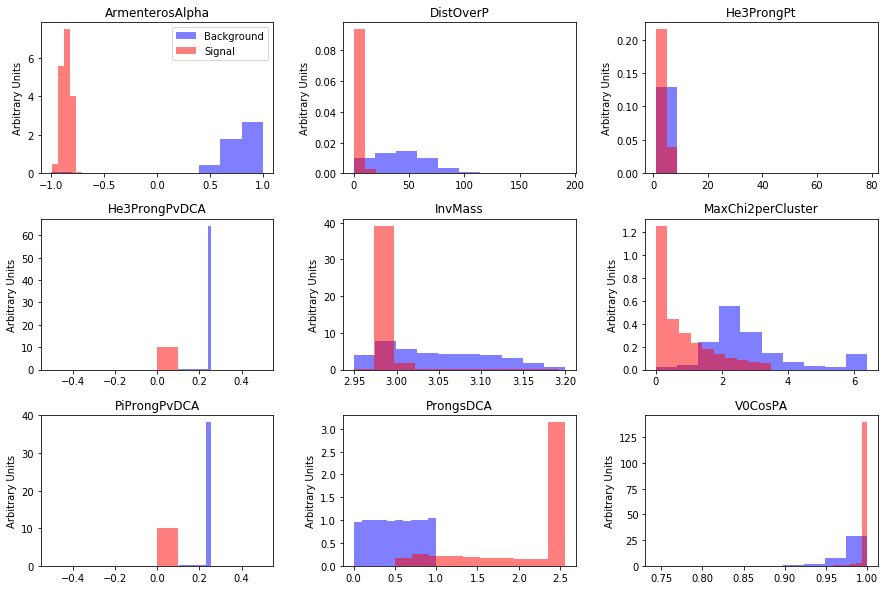

In [21]:
plot_distr(data,training_columns+['InvMass'])

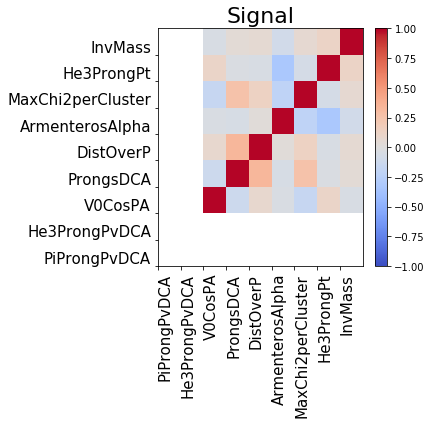

In [22]:
plot_corr(data,training_columns+['InvMass'],"Signal")

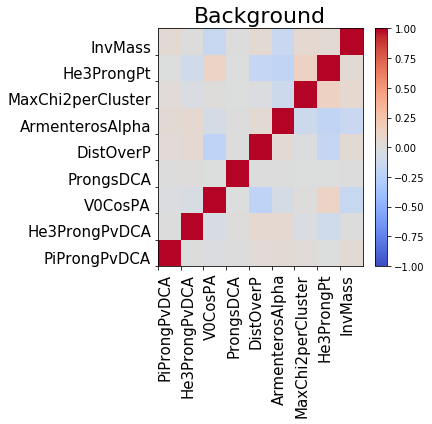

In [23]:
plot_corr(data,training_columns+['InvMass'],"Background")

In [24]:
y_target=data["y"]

In [13]:
data=data.drop(["y"],axis=1)

In [14]:
splitpoint=int(len(data)/2)


In [15]:
traindata=data[0:splitpoint]
ytrain=y_target[0:splitpoint]
testdata=data[splitpoint+1:]
ytest=y_target[splitpoint+1:]

## Parameters Optimization

Transforming in xgb Matrix. Optimization with cross validation,tuning of parameters, and final training

In [16]:
dtrain = xgb.DMatrix(data=traindata[training_columns], label=ytrain, feature_names=training_columns, silent=True)

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
dtest = xgb.DMatrix(data=testdata[training_columns], label=ytest, feature_names=training_columns, silent=True)

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [22]:
def optimize_params(dtrain,par):
    %run analysis_utils-Copy1.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
%time
nround = optimize_params(dtrain,params)

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 58.9 µs


In [ ]:
early_stopping_rounds

In [19]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

In [53]:
gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(7, 10, 1)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(7, 10, 1)]},
          }
params['max_depth'],params['min_child_weight'],_ = gs_2par(gs_dict, params, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    

In [31]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

## Test

Roc curve, feature importance, output of the model and distributions of the features with different cuts on bdt score

ROC_AUC traininig set: 0.746724


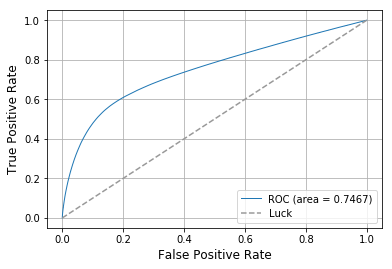

In [34]:
y_pred= best_model.predict(dtest,output_margin=True)
print(f"ROC_AUC traininig set: {roc_auc_score(ytest, y_pred):.6f}")
plot_roc(ytest, y_pred)

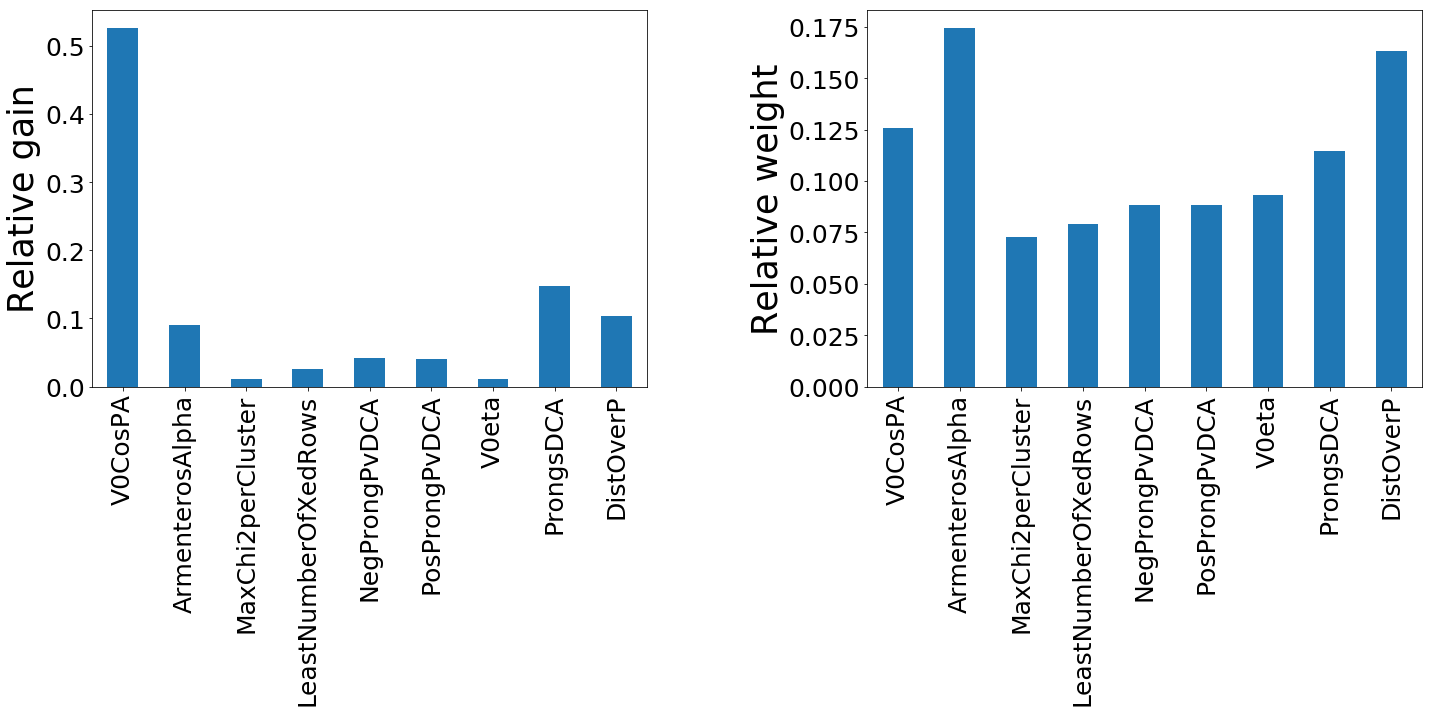

In [35]:
plot_feature_imp(best_model,['gain','weight'])

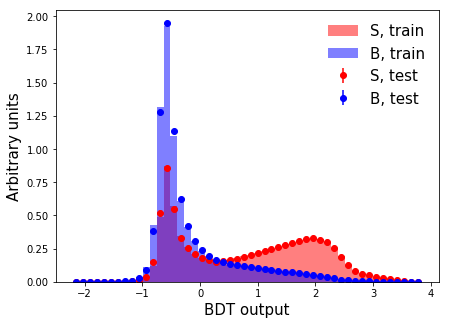

In [36]:
plot_output_train_test(best_model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

In [41]:
testdata['y']=ytest

/home/fmazzasc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


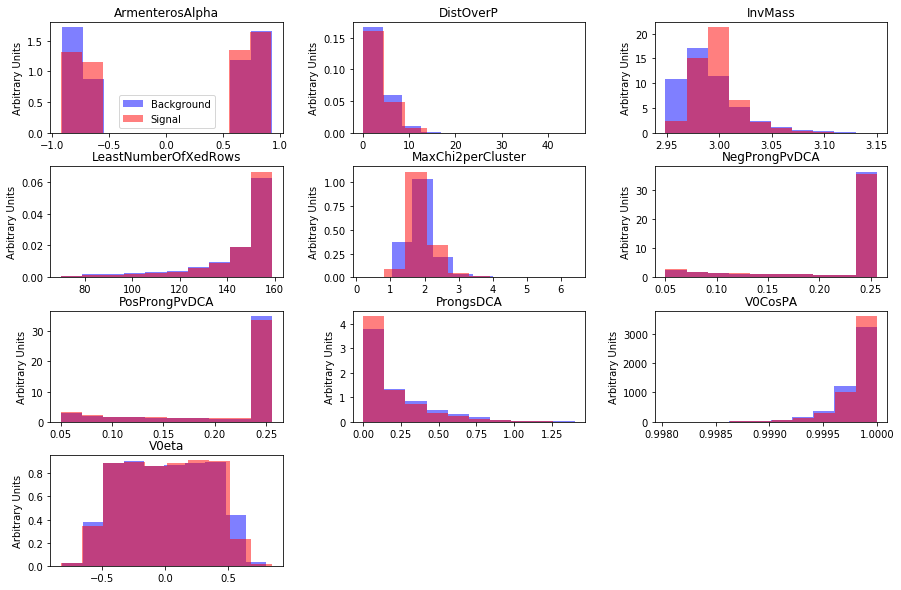

In [43]:
plot_distr(testdata[y_pred>1],training_columns+['InvMass'])